In [50]:
%pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels mpl_toolkits

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [51]:
#### Import all the needed packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting tool


In [52]:
csvFilePath = 'acc_data.csv'
df = pd.read_csv(csvFilePath)
df['sigma_sqrt_T'] = df['sigma'] * np.sqrt(df['T'])
df['H_log'] = abs(np.log(df['H'] / df['S0']))

# Prepare data for Cook's distance calculation
x = df['sigma_sqrt_T']
y = df['H_log']
x_with_constant = sm.add_constant(x)  # Adds a constant term to the predictor

# Fit the model
model = sm.OLS(y, x_with_constant).fit()
influence = model.get_influence()
cooks = influence.cooks_distance[0]

# Identify and remove outliers based on Cook's distance
threshold = 4 / len(x)
non_outliers = cooks < threshold

# Apply non-outliers filtering to the DataFrame
df = df[non_outliers]




In [53]:
def get_parameter_values(S0, K, T, r, q, sigma): 
    # d1 and d2 
    d1 = (np.log(S0/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
       
    # Lambda value 
    lambda_ = (r - q + 0.5 * sigma**2) / sigma**2
    
    # Vanilla call value
    c = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) 
    
    return lambda_, c

 
def down_and_call_book(S0, K, T, r, q, sigma,H, H_down, H_up):
    
    # Values for the different functions 
    lambda_, c = get_parameter_values(S0, K, T, r, q, sigma)
    
    # Value for the down and out
    y = np.log(H_down**2 / (S0*K)) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    
    # Values for the down and in 
    x1 = np.log(S0/H_up) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    y1 = np.log(H_up/S0) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)

    # Calculate option values for call
    if H <= K:
        #Down and out
        cdi = S0 * np.exp(-q * T) * (H_down/S0)**(2*lambda_) * norm.cdf(y) - K * np.exp(-r * T) * (H_down/S0)**(2*lambda_ - 2) * norm.cdf(y - sigma * np.sqrt(T))
        cdo = c  - cdi
        return cdo
    else:
        #Down and in
        cdo = S0 * np.exp(-q * T) * norm.cdf(x1) - K * np.exp(-r * T) * norm.cdf(x1 - sigma * np.sqrt(T)) 
        - S0 * np.exp(-q * T) * (H_up/S0)**(2*lambda_) * norm.cdf(y1) + K * np.exp(-r * T) * (H_up/S0)**(2*lambda_ - 2) * norm.cdf(y1 - sigma * np.sqrt(T))
        cdi = c - cdo
        
        return cdi


In [54]:
########## Adjust the barriers
def regression_beta_analytical(T, sigma, H, S0, m):
    H_log = abs(np.log(H/S0))
    prod = sigma * np.sqrt(T)
    beta_values = [0.5826, 0.6174, 0.6826, 0.7174]

    # Initialize beta to the lowest value by default
    beta = beta_values[0]
    
    # Define regression equations
    eq_2 = 0.1371*prod   # End of Beta 0.5826
    eq_3 = 0.0897*prod   # Start of Beta 0.6174
    eq_4 = 0.0496*prod   # End of Beta 0.6174
    eq_5 = 0.0467*prod   # Start of Beta 0.6826
    eq_6 = 0.0207*prod   # End of Beta 0.6826
    eq_7 = 0.0058*prod   # Start of Beta 0.7174

    # Check if product is less than 0.2
    if prod < 0.2:
        beta = beta_values[2]
        #print(f"Product is less than 0.2, setting beta to {beta_values[2]}")
    # Beta transition from 0.5826 to 0.6174 (linear interpolation)
    elif eq_3 < H_log <= eq_2:
        beta_range = beta_values[1] - beta_values[0]
        beta = ((H_log - eq_2) / (eq_3 - eq_2)) * beta_range + beta_values[0]
        #print(f"Linearly interpolating beta to {beta:.4f} between 0.5826 and 0.6174")
    # Beta is now a constant at 0.6174
    elif eq_4 < H_log <= eq_3:
        beta = beta_values[1]
        #print(f"Setting beta to {beta_values[1]}")
    # Beta is now a constant at 0.6826
    elif eq_6 < H_log <= eq_5:
        #beta = beta_values[2]
        beta = 0.6319 + -1.5993*H_log + 0.1149*prod
        #print(f"Setting beta to {beta_values[2]}")
    # Beta transition from 0.6826 to 0.7174 (linear interpolation) or setting to 0.7174
    elif eq_7 < H_log <= eq_6 and prod >= 0.2:
        beta_range = beta_values[3] - beta_values[2]
        beta = ((H_log - eq_6) / (eq_7 - eq_6)) * beta_range + beta_values[2]
        #print(f"Linearly interpolating beta to {beta:.4f} between 0.6826 and 0.7174")
    elif H_log <= eq_7 and prod >= 0.2:
        beta = beta_values[3]
        #print(f"Setting beta to {beta_values[3]}")

    return beta


# Function to adjust the barrier for discrete monitoring
def adjusted_barrier_analytical(T, H, S0,K, sigma, m):
    
    # dT should be here, it "is the time between monitoring instants", p.325, also stated in book from michael at p.628
    delta_T = T / m
    beta = regression_beta_analytical(T, sigma, H, S0, m)

    ### adjust the beta value
    H_adj_down = H * np.exp(-1 * beta * sigma * np.sqrt(delta_T))
    H_adj_up = H * np.exp(beta * sigma * np.sqrt(delta_T))

    return H_adj_down, H_adj_up

In [55]:
### Barrier engineer method
def regression_beta_engineer(T, sigma, H, S0):
    H_log = abs(np.log(H/S0))
    prod = sigma*np.sqrt(T)
    eq_6 = 0.0207*prod   # End of Beta 0.6826
    eq_7 = 0.0058*prod   # Start of Beta 0.7174
    
    ### Todo find a generalised function for this 
    h_increase = -0.0645*prod**2 + 0.1702*prod + 0.0041
    beta = 0.5826
    
    # From regresion_exp function
    if  H_log <= h_increase:
        beta = 0.6319 + -1.5993*H_log + 0.1149*prod

    if eq_7 < H_log <= eq_6 and prod >= 0.2:
       beta = 0.6973 + -2.9008*H_log + 0.0415*prod
        
    return beta

# Function to adjust the barrier for discrete monitoring
def adjusted_barrier_engineer(T, H, S0,sigma, m):
    
    # dT should be here, it "is the time between monitoring instants", p.325, also stated in book from michael at p.628
    delta_T = T / m
    beta = regression_beta_engineer(T, sigma, H, S0)

    ### adjust the beta value
    H_adj_down = H * np.exp(-1 * beta * sigma * np.sqrt(delta_T))
    H_adj_up = H * np.exp(beta * sigma * np.sqrt(delta_T))

    return H_adj_down, H_adj_up

Maximum Error - Original Method: 13.6094%
Maximum Error - Custom Engineer: 1.0270%
Maximum Error - Custom Analytical: 1.7046%


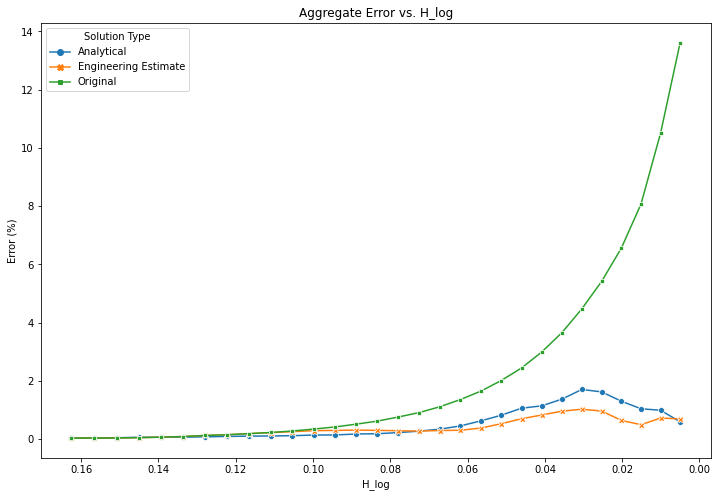

In [56]:

# Initialize a list to store error calculations
errors = []

for index, row in df.iterrows():
    q = 0
    r = 0.1 
    m = 50
    
    # Extract necessary values from the row
    T, H, S0, K, sigma = row['T'], row['H'], row['S0'], row['K'], row['sigma']
    H_log = abs(np.log(row['H']/row['S0']))
    
    # Analytical solution
    beta_analytical = regression_beta_analytical(T, sigma, H, S0, m)  # Get beta for analytical solution
    H_down_analytical, H_up_analytical = adjusted_barrier_analytical(T, H, S0, K, sigma, m)
    price_analytical = down_and_call_book(S0, K, T, r, q, sigma, H, H_down_analytical, H_up_analytical)
    
    # Engineering solution
    beta_engineer = regression_beta_engineer(T, sigma, H, S0)  # Get beta for engineering estimate
    H_down_engineer, H_up_engineer = adjusted_barrier_engineer(T, H, S0,sigma, m)
    price_engineer = down_and_call_book(S0, K, T, r, q, sigma, H, H_down_engineer, H_up_engineer)
    
    # Assuming price_original and price_iter are columns in df representing original and Monte Carlo prices
    price_mc = row['price_iter']
    error_original = round(abs(((price_mc - row['price_adj']) / price_mc) * 100), 4)
    error_analytical = round(abs(((price_mc - price_analytical) / price_mc) * 100), 4)
    error_engineer = round(abs(((price_mc - price_engineer) / price_mc) * 100), 4)
        
    errors.append({'H_log': H_log, 'Error': error_original, 'Type': 'Original'})
    errors.append({'H_log': H_log, 'Error': error_engineer, 'Type': 'Engineering Estimate'})
    errors.append({'H_log': H_log, 'Error': error_analytical, 'Type': 'Analytical'})

    best_beta = row['best_beta']
    # Print scenarios where custom errors are larger than 1% including T, Sigma, H, and S0
    if error_engineer > 1:
        #print(f"Engineering Error > 1% - T: {T}, Sigma: {sigma}, H: {H}, S0: {S0}, Beta: {beta_engineer}, Best_beta: {best_beta},  Error: {error_engineer}%")
        variable = 0
    if error_analytical > 1:
        #print(f"Analytical Error > 1% - T: {T}, Sigma: {sigma}, H: {H}, S0: {S0}, Beta: {beta_analytical}, Best_beta: {best_beta}, Error: {error_analytical}%")
        variable = 0

# Convert errors list to DataFrame for plotting
df_errors = pd.DataFrame(errors)

# Aggregate errors by H_log and Type
df_agg = df_errors.groupby(['H_log', 'Type'], as_index=False)['Error'].mean()

# Find the maximum error values for each method
max_error_original = df_agg[df_agg['Type'] == 'Original']['Error'].max()
max_error_engineer = df_agg[df_agg['Type'] == 'Engineering Estimate']['Error'].max()
max_error_analytical = df_agg[df_agg['Type'] == 'Analytical']['Error'].max()

print(f"Maximum Error - Original Method: {max_error_original:.4f}%")
print(f"Maximum Error - Custom Engineer: {max_error_engineer:.4f}%")
print(f"Maximum Error - Custom Analytical: {max_error_analytical:.4f}%")

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_agg, x='H_log', y='Error', hue='Type', style='Type', markers=True, dashes=False)
plt.title('Aggregate Error vs. H_log')
plt.xlabel('H_log')
plt.ylabel('Error (%)')
plt.legend(title='Solution Type')
plt.gca().invert_xaxis()  # Invert the x-axis to have the largest H_percent start on the left
plt.show()
